In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
from fastai.text.all import *
from reformer_fastai.all import *
from timeit import timeit

In [ ]:
#hide
#skip
torch.cuda.set_device(0)

In [ ]:
#hide
#all_slow

# LSH evaluation speed

We want to test the speed of during evaluation in seconds per step, as reported in the right part of table 5 of the paper: https://arxiv.org/pdf/2001.04451.pdf

![image.png](images/table-lsh-speed.png)

## get data

Helper method to get data. Assume 1 step of training and 10 of validation.

In [ ]:
def get_dataloaders(bs=32, sl=1024, train_steps=1, valid_steps=10, seed=123):
    train_sz, valid_sz = bs*train_steps, bs*valid_steps

    dls = DataLoaders.from_dsets(DeterministicTwinSequence(sl, train_sz, seed=seed), 
                                 DeterministicTwinSequence(sl, valid_sz, seed=seed), 
                                 bs=bs, shuffle=False, device='cuda')
    return dls

## get model

Helper method to get `LSHLM` method. If `n_hashes=0` full attention is used.

In [ ]:
def get_lshlm(n_hashes=1, sl=1024, use_lsh=True):
    if n_hashes==0: use_lsh=False
    return LSHLM(vocab_sz=128, d_model=256, n_layers=1, n_heads=4, 
              max_seq_len=sl,bucket_size=64, n_hashes=n_hashes, 
              causal=True, use_lsh=use_lsh)

## train

Get a learner that is trained for 1 epoch (just in case).

In [ ]:
def get_learner(dls, model, n_epochs=1, lr=1e-3):
    learn = Learner(dls, model, opt_func=adafactor, 
                loss_func=CrossEntropyLossFlat(ignore_index=-100), 
                metrics=MaskedAccuracy(), 
                cbs=[MaskTargCallback()]).to_fp16()
    with learn.no_bar():
        with learn.no_logging():
            learn.fit(n_epochs, lr)
    return learn

## time evaluation

In [ ]:
'function to get average time per step of validation'
def time_eval(learn,dls, n_rounds=10):
    with learn.no_bar():
        t = timeit(learn.validate, number=n_rounds)
    steps = dls.valid.n / dls.valid.bs
    return t / n_rounds / steps

# Loop experiment setup

In [ ]:
n_lsh=[0, 1,2,4,8]
sls   =[1024, 2048, 4096, 8192, 16384, 32768]
bss   =[32, 16, 8, 4, 2, 1]
train_steps, valid_steps = 1,10

In [ ]:
cols = ['sl', 'bs', 'n-lsh', 'time']
results = []
for sl, bs in zip(sls, bss):
    for n_hashes in n_lsh:
        if n_hashes==0 and sl>8192:
            results.append((sl, bs, n_hashes, np.nan)) # won't fit in memory
        else:
            dls = get_dataloaders(bs=bs, sl=sl, train_steps=train_steps, valid_steps=valid_steps)
            model = get_lshlm(n_hashes=n_hashes, sl=sl)
            learn = get_learner(dls, model)
            t = time_eval(learn, dls)
            del(learn, model, dls)
            torch.cuda.empty_cache()
            results.append((sl, bs, n_hashes, t))

In [ ]:
df = pd.DataFrame(results, columns=cols)
df.head()

,sl,bs,n-lsh,time
0,1024,32,0,0.072765
1,1024,32,1,0.068335
2,1024,32,2,0.089546
3,1024,32,4,0.150253
4,1024,32,8,0.348131


In [ ]:
df.to_csv('lsh-timing.csv')

In [ ]:
def get_label(nh):
    return f'lsh-{nh}' if nh>0 else 'full attention'
def get_linestyle(nh):
    return '--' if nh == 0 else '-'

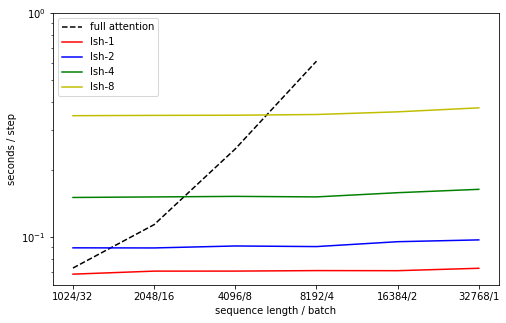

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
for nh, c in zip(n_lsh, ['k','r', 'b', 'g', 'y']):
    dat = df.loc[df['n-lsh']==nh]
    ax.plot(dat['sl'], dat['time'], color=c, label=get_label(nh), linestyle=get_linestyle(nh))
ax.set_yscale('log')
ax.set_xscale('log', basex=2)

ax.set_xlabel('sequence length / batch')
ax.set_yticks([0.1, 1])
ax.set_xticks(sls)
ax.set_xticklabels(f'{sl}/{bs}' for sl, bs in zip(sls, bss))
ax.legend(loc='upper left')
ax.set_ylabel('seconds / step');

![image.png](images/table-lsh-speed.png)

We were unable to to do the full sequence length for full attention due to out of memory errors on a single gpu. The results for the smaller sequences are mostly matching, except for lsh-8 which in our experiments turn out slower than in the paper. Also, our full attention seems to be a bit faster. In general results looks offset by a constant. This could be due to method of measurement or architecture choices.